In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from joblib import dump

In [2]:
TRAIN_DATA = os.path.join('..', '..', 'datasets', 'cup2023', 'ML-CUP23-TR.csv')
IMAGES_FOLDER = os.path.join('..', '..', 'images', 'cup2023', 'random_forest')
MODEL_FOLDER = os.path.join('..', '..', 'trained_models', 'cup2023')

# Utilities

In [3]:
def save_model(filename, model):

    if not filename.endswith('.joblib'):
        filename += '.joblib'

    model_path = os.path.join(MODEL_FOLDER, filename)
    dump(model, model_path, compress=3)

In [4]:
def plot_and_save_learning_curve(model, filename, format='png'):

    if not filename.endswith(format):
        filename += format

    train_sizes, train_scores, validation_scores = learning_curve(
        estimator=model,
        X=X_train,
        y=y_train,
        train_sizes=[0.1, 0.33, 0.55, 0.78, 1.],
        cv=5,
        scoring='r2'
    )


    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)
    plt.figure()
    plt.title('Learning curve')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.grid()

    # Filling the area around the mean scores to indicate variability of the model's performance
    # The shaded area represents the range of scores (mean ± standard deviation) for each training set size
    plt.fill_between(
        train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='r'
    )
    plt.fill_between(
        train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color='g'
    )

    # Mean score lines for training and validation
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
             label='Training score')
    plt.plot(train_sizes, validation_scores_mean, 'o-', color='g',
             label='Cross-validation score')

    plt.legend(loc='best')

    fig_path = os.path.join(IMAGES_FOLDER, filename)
    plt.savefig(fig_path, format=format)

    plt.show()

# Import data

In [5]:
# To skip the first column (row indexes)
columns_to_read = list(range(1, 14))

df_train = pd.read_csv(TRAIN_DATA, header=None, comment='#', usecols=columns_to_read)
df_train.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.917280,-0.712727,-0.989904,0.992819,0.993649,0.995543,0.711074,0.407645,-0.688548,0.616890,7.897453,-35.936382,21.077147
1,-0.858784,0.998755,-0.998396,0.999909,0.316503,-0.951897,-0.163139,0.980982,0.661759,-0.800155,-9.330632,19.901571,6.069154
2,-0.990441,0.958726,-0.998675,0.997216,0.987166,0.356483,-0.279689,0.599163,-0.684630,0.922901,14.849400,3.374090,19.667479
3,0.937117,0.984474,-0.612420,0.999812,0.728623,-0.539962,-0.165939,0.999352,-0.921444,-0.974766,-46.591854,13.734777,17.953600
4,-0.906628,-0.884567,-0.932487,0.941037,0.978134,0.998179,0.749606,-0.590599,-0.508268,0.691798,8.217500,-45.885254,14.894251


In [6]:
features = ['feature_' + str(i) for i in range(1, 11)]
targets = ['target_x', 'target_y', 'target_z']

# Rename columns
new_column_names = features + targets
df_train.columns = new_column_names

df_train.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,target_x,target_y,target_z
0,-0.917280,-0.712727,-0.989904,0.992819,0.993649,0.995543,0.711074,0.407645,-0.688548,0.616890,7.897453,-35.936382,21.077147
1,-0.858784,0.998755,-0.998396,0.999909,0.316503,-0.951897,-0.163139,0.980982,0.661759,-0.800155,-9.330632,19.901571,6.069154
2,-0.990441,0.958726,-0.998675,0.997216,0.987166,0.356483,-0.279689,0.599163,-0.684630,0.922901,14.849400,3.374090,19.667479
3,0.937117,0.984474,-0.612420,0.999812,0.728623,-0.539962,-0.165939,0.999352,-0.921444,-0.974766,-46.591854,13.734777,17.953600
4,-0.906628,-0.884567,-0.932487,0.941037,0.978134,0.998179,0.749606,-0.590599,-0.508268,0.691798,8.217500,-45.885254,14.894251


In [7]:
X_train = df_train[features].to_numpy()
y_train = df_train[targets].to_numpy()

y_train_tx = y_train[:, 0]
y_train_ty = y_train[:, 1]
y_train_tz = y_train[:, 2]

# First model: target x

In [8]:
model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [9]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train_tx)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [10]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print('Best parameters:', best_params)
print('Best score:', grid_search.best_score_)

Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best score: 0.9950185257171661


In [11]:
final_model = RandomForestRegressor(**best_params)
final_model.fit(X_train, y_train_tx)

RandomForestRegressor(max_depth=20, n_estimators=300)

### Learning curve

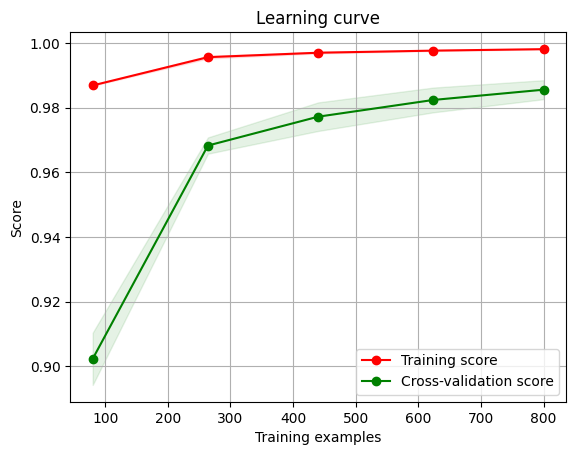

In [12]:
plot_and_save_learning_curve(final_model, 'learning_curve_target_x')

### Save model

In [13]:
save_model('random_forest_model_target_x', final_model)

# Second model: target y